In [ ]:
!pip install alpha_vantage


In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

# Initialize the TimeSeries class with your API key
ts = TimeSeries(key='D8LSWOO18XT5BUK6', output_format='pandas')

# Retrieve daily time series data for a given symbol
symbol = 'AAPL'
data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

# Clean up column names by stripping whitespace and removing numeric prefixes
data.columns = [col.strip() for col in data.columns]
data = data.rename(columns=lambda x: x.split('. ')[-1])

# Specify the file path where you want to save the CSV
csv_file_path = 'AAPL_daily_data.csv'

# Save the data to a CSV file
data.to_csv(csv_file_path)

print(f'Data has been saved to {csv_file_path}')


Data has been saved to AAPL_daily_data.csv


In [ ]:
df=pd.read_csv('/content/AAPL_daily_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6190 entries, 0 to 6189
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6190 non-null   object 
 1   open    6190 non-null   float64
 2   high    6190 non-null   float64
 3   low     6190 non-null   float64
 4   close   6190 non-null   float64
 5   volume  6190 non-null   float64
dtypes: float64(5), object(1)
memory usage: 290.3+ KB


In [ ]:
df.head()

,date,open,high,low,close,volume
0,2024-06-07,194.650,196.94,194.1400,196.89,53103912.0
1,2024-06-06,195.685,196.50,194.1700,194.48,41181753.0
2,2024-06-05,195.400,196.90,194.8700,195.87,54156785.0
3,2024-06-04,194.635,195.32,193.0342,194.35,47471445.0
4,2024-06-03,192.900,194.99,192.5200,194.03,50080539.0


In [ ]:
d1=df.reset_index()['close']

In [ ]:
d1.shape

(6190,)

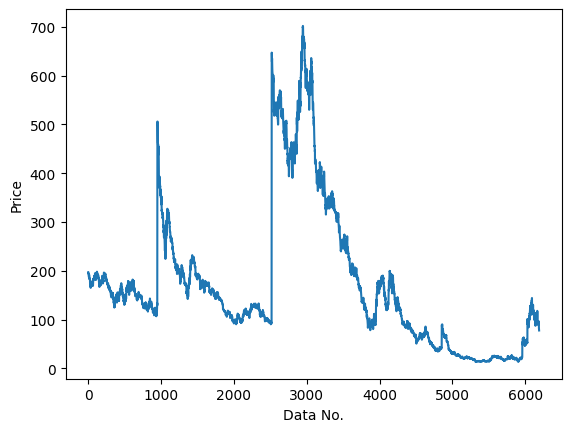

In [ ]:
import matplotlib.pyplot as plt

# Create a range of numbers for the x-axis
x_data = range(len(d1))

# Plot the data
plt.plot(x_data, d1)

# Set the labels for the axes
plt.xlabel("Data No.")
plt.ylabel("Price")

# Show the plot
plt.show()

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
d1=scaler.fit_transform(np.array(d1).reshape(-1,1))

In [ ]:
print(d1)

[[0.26672763]
 [0.2632297 ]
 [0.26524718]
 ...
 [0.09924816]
 [0.09743389]
 [0.09361665]]


In [ ]:
train_s=int(len(d1)*0.7)
test_s=len(d1)-train_s

In [ ]:
train_s

4333

In [ ]:
train_data,test_data=d1[0:train_s,:],d1[train_s:len(d1),:1]

In [ ]:
def create_dataset(dataset,time_step=1):
  datax,datay=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    datax.append(a)
    datay.append(dataset[i+time_step,0])
  return np.array(datax),np.array(datay)

In [ ]:
time_split=100
x_train,y_train=create_dataset(train_data,time_split)
x_test,y_test=create_dataset(test_data,time_split)

In [ ]:
x_train.shape

(4232, 100)

In [ ]:
y_train.shape

(4232,)

In [ ]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
67/67 [==============================] - 13s 61ms/step - loss: 0.0076 - val_loss: 5.1287e-04
Epoch 2/100
67/67 [==============================] - 3s 41ms/step - loss: 0.0019 - val_loss: 2.7898e-04
Epoch 3/100
67/67 [==============================] - 3s 40ms/step - loss: 0.0016 - val_loss: 3.9025e-04
Epoch 4/100
67/67 [==============================] - 2s 34ms/step - loss: 0.0015 - val_loss: 2.7570e-04
Epoch 5/100
67/67 [==============================] - 2s 25ms/step - loss: 0.0013 - val_loss: 9.5150e-05
Epoch 6/100
67/67 [==============================] - 2s 31ms/step - loss: 0.0012 - val_loss: 1.7183e-04
Epoch 7/100
67/67 [==============================] - 2s 32ms/step - loss: 0.0011 - val_loss: 9.7202e-05
Epoch 8/100
67/67 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 1.2137e-04
Epoch 9/100
67/67 [==============================] - 1s 19ms/step - loss: 9.3494e-04 - val_loss: 3.2165e-04
Epoch 10/100
67/67 [==============================] - 2s 23

In [ ]:
trainpre=model.predict(x_train)
testpre=model.predict(x_test)

55/55 [==============================] - 0s 5ms/step


In [ ]:
trainpre=scaler.inverse_transform(trainpre)
testpre=scaler.inverse_transform(testpre)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,testpre))

53.04210672474869

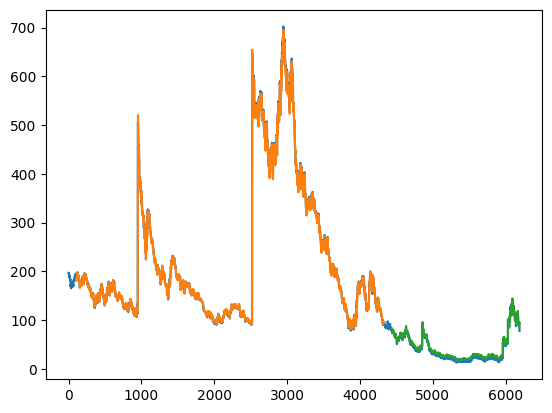

In [ ]:
#plot the predicted
look_back=100
trainPredictPlot = np.empty_like(d1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainpre)+look_back, :] = trainpre
# shift test predictions for plotting
testPredictPlot = np.empty_like(d1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainpre)+(look_back*2)+1:len(d1)-1, :] = testpre
# plot baseline and predictions
plt.plot(scaler.inverse_transform(d1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

1857

In [ ]:
x_input=test_data[1757:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1




[0.09666967]
101
1 day input [0.19023774 0.1768121  0.15948213 0.16238497 0.15739209 0.14968504
 0.1467822  0.15702923 0.16347354 0.15839357 0.15803071 0.15929345
 0.16338646 0.16673924 0.15803071 0.17009202 0.14731923 0.14533078
 0.14115069 0.14816105 0.14968504 0.14614357 0.14242794 0.14768208
 0.14659352 0.15367645 0.14904642 0.13879938 0.14569363 0.14441638
 0.14768208 0.14650643 0.13771082 0.13090365 0.12437226 0.12646231
 0.13154228 0.12845075 0.14061366 0.14088943 0.14387936 0.13517083
 0.14251502 0.14569363 0.13562077 0.13181805 0.12673808 0.12138233
 0.10750675 0.11557665 0.12283375 0.12537374 0.11884235 0.13190514
 0.129728   0.14342942 0.13017794 0.12654939 0.12710093 0.12347238
 0.12509797 0.13117942 0.12601237 0.129728   0.12319661 0.12609945
 0.12364655 0.12174519 0.11865366 0.12464803 0.13045371 0.13371941
 0.14070075 0.15194926 0.14932219 0.14787077 0.14088943 0.1305408
 0.12300792 0.11820372 0.11892943 0.11839241 0.11566373 0.11248512
 0.11512671 0.1110337  0.1119481  

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(d1)

6190

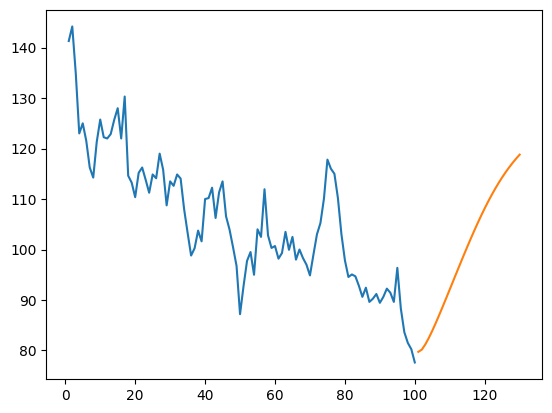

In [ ]:
plt.plot(day_new,scaler.inverse_transform(d1[6090:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

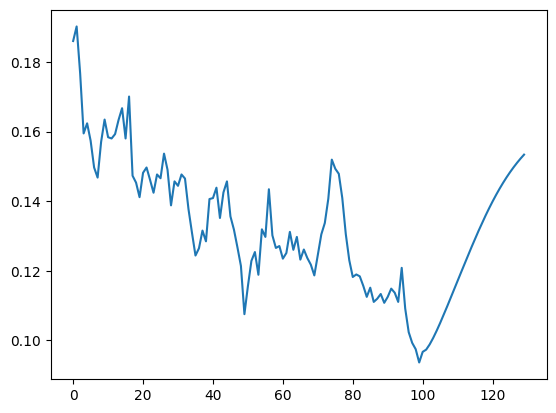

In [ ]:
d3=d1.tolist()
d3.extend(lst_output)
plt.plot(d3[6090:])

In [ ]:
df3=scaler.inverse_transform(d3).tolist()

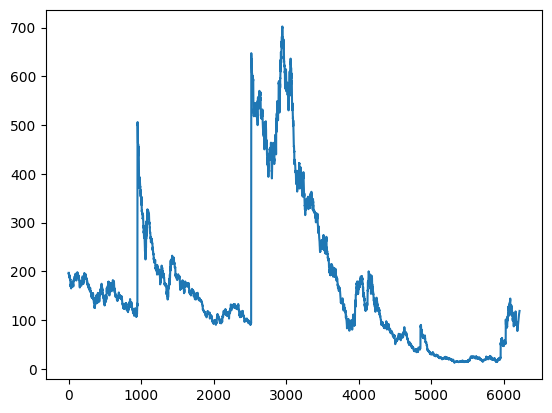

In [ ]:
plt.plot(df3)